# Dr Dennett's guide to Spatial Interaction Modelling - Part 1: The Unconstrained (Total Constrained) Model
Code  translated from R to Python by Philip Wilkinson and revised by Elsa Arcaute.

Please refer to the first weeks practicals regarding Python, and in case of doubt let us know.

If you have installed the environments, all packages that are required should already be installed, and we can simply import all the packages that we may need. If not, remember to FIRST install them, e.g. via pip install BEFORE importing them.

In [580]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

## Setting up some spatial data

Make sure you have the data downloaded to the same folder as your notebook.

![Image of Data Structure](./Images/Data_Folder.PNG)

As the name suggests, to run a spatial model you are going to need some spatial data and some data on interactions (flows). Let's start with some spatial data.

In [581]:
#Fetch a GeoJson of some district-level boundaries from the ONS Geoportal. First add the URL to an object
#For a WINDOWS PC, use the following path:
#file = ".\Data\LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson"
#For a MAC, use the following path:
file = "./Data/LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson"
EW = gpd.read_file(file)

Check to make sure the boundaries have downloaded OK...

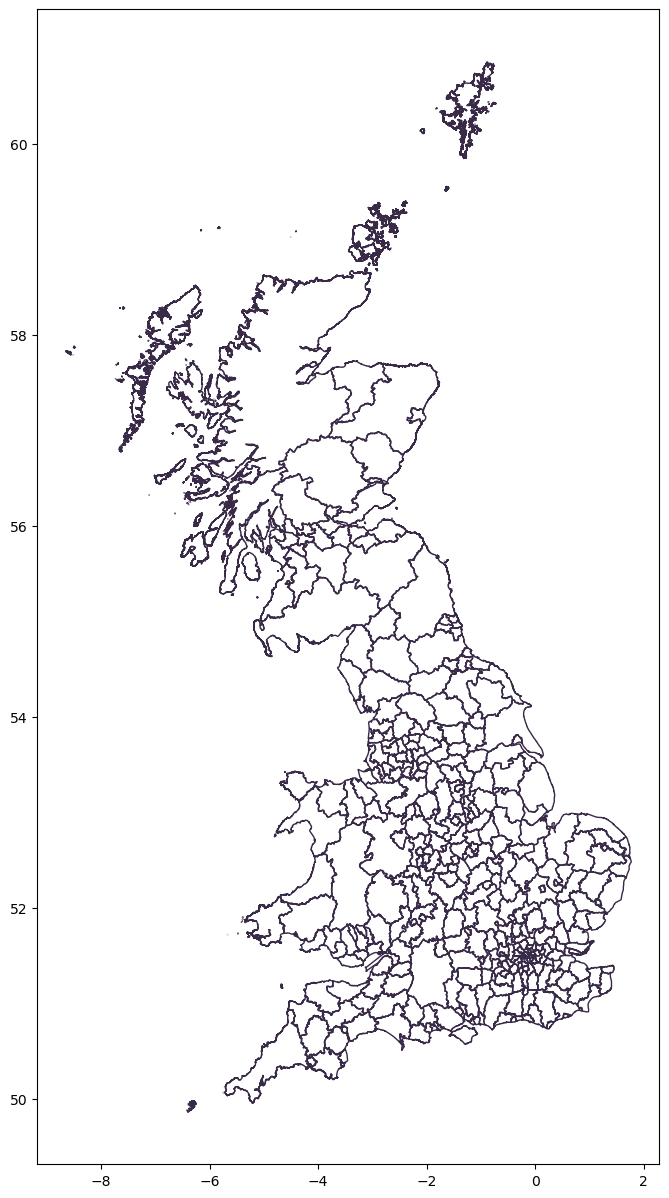

In [582]:
EW.plot(figsize = (10,15), facecolor = "None", edgecolor = '#392A48')
plt.show()

In [583]:
EW.head(10)

,OBJECTID,lad15cd,lad15nm,lad15nmw,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,E06000001,Hartlepool,,{A378C88C-F07E-44BA-9AA9-A46B5F0979FA},0.827152,0.013716,"MULTIPOLYGON (((-1.26846 54.72612, -1.26822 54..."
1,2,E06000002,Middlesbrough,,{69FF326A-E5E5-4A2C-A08F-44E8577738B9},0.525768,0.007577,"MULTIPOLYGON (((-1.25112 54.59153, -1.24953 54..."
2,3,E06000003,Redcar and Cleveland,,{9FD9EADF-7281-4E65-AA7A-53A3CE12257F},1.330151,0.035273,"MULTIPOLYGON (((-1.13633 54.64504, -1.13616 54..."
3,4,E06000004,Stockton-on-Tees,,{DA8AE60D-78D7-403A-91A0-8CDDA8BF8903},1.331992,0.029146,"MULTIPOLYGON (((-1.31729 54.6448, -1.31715 54...."
4,5,E06000005,Darlington,,{94C7C82E-CA6C-4265-9DE9-8EEE7CD47A1F},1.334490,0.027434,"MULTIPOLYGON (((-1.63768 54.61714, -1.63767 54..."
5,6,E06000006,Halton,,{E63E3237-3806-4032-A9E1-4E892CDBA3F2},0.753921,0.012194,"MULTIPOLYGON (((-2.73037 53.39989, -2.72894 53..."
6,7,E06000007,Warrington,,{F67CDF76-658B-4D97-83BA-3BD64918BBDE},1.020898,0.024654,"MULTIPOLYGON (((-2.49407 53.4801, -2.49396 53...."
7,8,E06000008,Blackburn with Darwen,,{8A939D3C-CABB-47DE-B651-7638D697C53B},0.764892,0.018650,"MULTIPOLYGON (((-2.4685 53.78164, -2.46838 53...."
8,9,E06000009,Blackpool,,{5E049AAE-17AF-484A-885F-616C30CC306C},0.413505,0.005890,"MULTIPOLYGON (((-3.02048 53.85938, -3.02038 53..."
9,10,E06000010,"Kingston upon Hull, City of",,{C399AB05-48FE-4A16-BB4E-3BF58E33FC3A},0.577911,0.011107,"MULTIPOLYGON (((-0.31613 53.81327, -0.3125 53...."


For the time being let us extract London which corresponds to "E09" from the "lad15cd" column

In [584]:
London = EW[EW.lad15cd.str.contains("E09")]

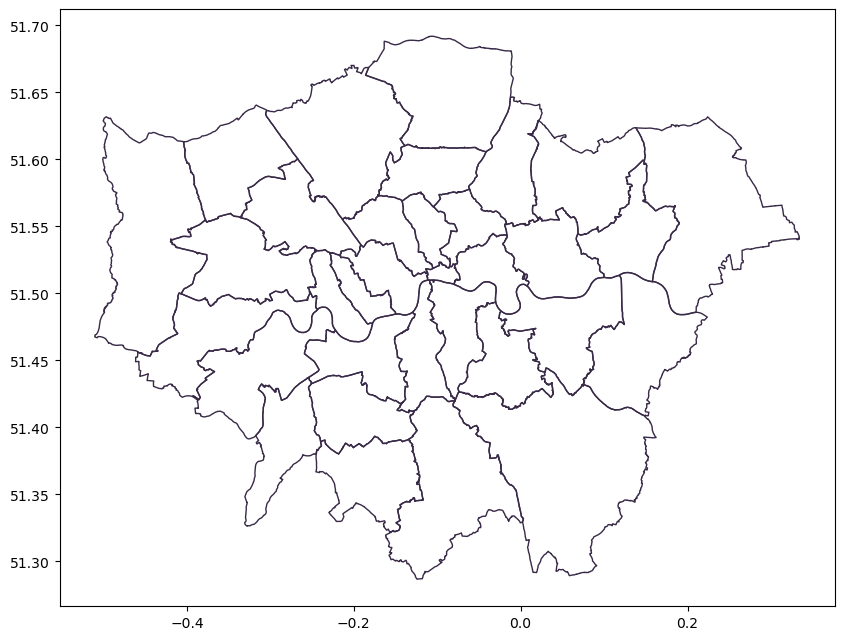

In [585]:
London.plot(figsize = (10,15), facecolor = "None", edgecolor = '#392A48')
plt.show()

In [586]:
#look under the bonnet
London.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [587]:
London.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 33 entries, 293 to 325
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      33 non-null     int32   
 1   lad15cd       33 non-null     object  
 2   lad15nm       33 non-null     object  
 3   lad15nmw      33 non-null     object  
 4   GlobalID      33 non-null     object  
 5   SHAPE_Length  33 non-null     float64 
 6   SHAPE_Area    33 non-null     float64 
 7   geometry      33 non-null     geometry
dtypes: float64(2), geometry(1), int32(1), object(4)
memory usage: 2.2+ KB


## Calculating a distance matrix

Now we have a nice clean set of London Boundaries, let's extract some spatial data. Of course, the important spatial data for spatial interaction models relates to the cost of interaction between places and this is very frequently represented through distance...

If you look at the crs above, the boundaries are not in the British National Grid Projection, as we can see that the CRS is WGS84, indicating longitude and latitude coordinates. We need to change this to the British National grid so that our distances are in metres and not decimal degrees, then we need to generate a distance matrix.

C:\Users\Owen Hughes\anaconda3\envs\urbsim\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


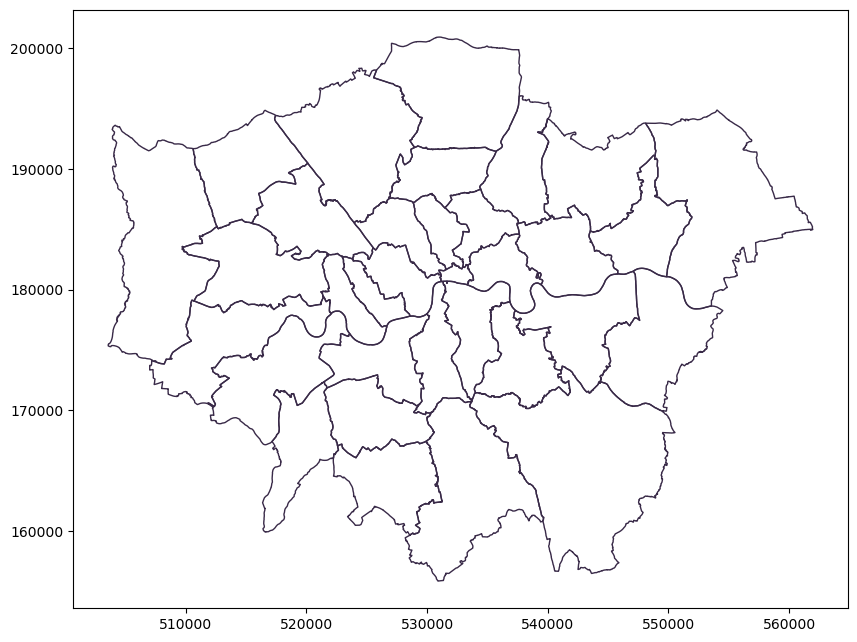

In [588]:
#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = '#392A48')
plt.show()

In [589]:
London.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

**We Can see the CRS has now been changed to 27700**
* As mentioned above, this was visible on the graph axes as well

In [590]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace = True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1562280150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London.sort_values(by=["lad15cd"], inplace = True)
C:\Users\Owen Hughes\anaconda3\envs\urbsim\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**I want to check what the new order looks like**

In [591]:
London.head(5)

,OBJECTID,lad15cd,lad15nm,lad15nmw,GlobalID,SHAPE_Length,SHAPE_Area,geometry,Centroids
293,294,E09000001,City of London,,{3EAFED65-724F-4C7D-8B6D-5662D3418167},0.116613,0.000408,"MULTIPOLYGON (((532140.312 182191.903, 532141....",POINT (532462.387 181223.441)
294,295,E09000002,Barking and Dagenham,,{AC9DC0D2-23FC-4DCC-B0D3-222C721DAB62},0.431757,0.004898,"MULTIPOLYGON (((548881.813 190803.003, 548881....",POINT (548019.605 184940.569)
295,296,E09000003,Barnet,,{A202F086-4FB5-405A-9E2A-BC75E8B01741},0.591382,0.011261,"MULTIPOLYGON (((524579.913 198355.204, 524594....",POINT (524027.608 192316.344)
296,297,E09000004,Bexley,,{FE34DFED-7474-48E0-95E3-037EEBE7929B},0.507987,0.008316,"MULTIPOLYGON (((552176.813 178417.803, 552296....",POINT (548926.821 175720.3)
297,298,E09000005,Brent,,{C8EC85F7-D404-4D3E-999C-E4BADB3EBB3E},0.464245,0.005605,"MULTIPOLYGON (((520284.713 190241.404, 520319....",POINT (520177.882 185829.52)


**Alphabetical order with the exception of City of London taking the first spot?**

In [592]:
London.set_index('lad15cd', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

In [593]:
print(distances.head(5))
leng = len(distances)
print(f'The distances matrix has {leng} rows and columns')

        Orig       Dest          Dist
0  E09000001  E09000001      0.000000
1  E09000001  E09000002  15995.126280
2  E09000001  E09000003  13935.493781
3  E09000001  E09000004  17359.785331
4  E09000001  E09000005  13119.643266
The distances matrix has 1089 rows and columns


In [594]:
#Given that we have converted to the BNG already, this means that we could simply compute the Euclidean distance
#which can be done with this code
#uncomment if you wish

#drop any uncessary columns
#LDN_cent = London.drop(columns = ["objectid", "lad15nm", "lad15nmw", "st_areashape", "st_lengthshape", "geometry"])

#extract the x and y coordinates
#LDN_cent["x"] = LDN_cent["Centroids"].map(lambda p: p.x)
#LDN_cent["y"] = LDN_cent["Centroids"].map(lambda p: p.y) 

#you can now drop the centroids
#LDN_cent.drop(columns =[ "Centroids"], inplace = True)

#extract the distances for each possible pair
#distances = []
#for index1, row1 in LDN_cent.iterrows():
#    for index2, row2 in LDN_cent.iterrows():
#        #append the orig code, destination code and distance
#        distances.append([row1["lad15cd"], row2["lad15cd"], 
#                          ((float(row1["x"])-float(row2["x"]))**2 +(float(row1["y"])-float(row2["y"]))**2)**0.5])
        
#convert the resulting list into a dataframe        
#distances = pd.DataFrame.from_records(distances, columns = ["Orig", "Dest", "Dist"])

#sort by origin code and then destination code
#distances.sort_values(by=["Orig", "Dest"], inplace = True)

#check the results
#distances

## Flow data

The data we are going to use to test our spatial interaction models is with commuting data from the 2001 England and Wales Census. In the Census, there is a question which asks your home address and another which asks the location of your usual place of work, as well as the method of transport that you mainly use to conduct your commute. From this, estimates of commuter flows by transportation type for the whole country can be generated.

In this exercise, to save time, I have already downloaded some sample data which records the place (Borough) or residence and place (Borough) of work for all people living in London at the time of the 2001 Census. Borough level is quite coarse but it will suffice for demonstration purposes. If you would like to download your own commuting or migration flow data, then you should visit the Census Support Flow Data Service called wicid - https://wicid.ukdataservice.ac.uk/ - here you can download flows for a huge range of geographies from the 1981, 1991, 2001 and 2011 Censuses.

As well as flow data, I have also collected some additional data on income, the number of jobs in each borough in 2001 and the total population - we will uses these as destination atractiveness/mass term and origin emissiveness/mass term proxies in the models which follow.

In [595]:
import requests
print(requests.get("https://www.dropbox.com/s/7c1fi1txbbvhdqby/LondonCommuting2001.csv?raw=1").text[:300])


<!DOCTYPE html>
<html class="maestro global-header" xmlns="http://www.w3.org/1999/xhtml" lang="en">
<head><meta charset="utf-8" />
<meta content="noindex, nofollow, noimageindex" name="robots" />
<meta content="width=device-width, initial-scale=1" name="viewport" />
<script nonce="bm1SZdDV9BuGtNQeIu


In [596]:
#Read in your London Commuting Data
cdata = pd.read_csv("data/commuters.csv")
nwlkp = pd.read_csv("data/newlookup.csv")
#Read in a lookup table for translating between old borough codes and new borough codes
#CodeLookup = pd.read_csv("https://www.dropbox.com/s/h8mpvnepdkwa1ac/CodeLookup.csv?raw=1")
#rRead in some population and income data
#popincome = pd.read_csv("https://www.dropbox.com/s/84z22a4wo3x2p86/popincome.csv?raw=1")

In [597]:
cdata.tail(20)

,Area of usual residence,Area of workplace,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work
110142,W40000022,W40000003,1,0,0,0,0,0,0,1,0,0,0,0
110143,W40000022,W40000004,3,0,0,0,0,0,0,2,1,0,0,0
110144,W40000022,W40000005,1,0,0,0,0,0,0,1,0,0,0,0
110145,W40000022,W40000006,4,0,0,0,0,0,0,3,1,0,0,0
110146,W40000022,W40000007,4,0,0,0,0,0,0,4,0,0,0,0
110147,W40000022,W40000008,12,0,0,0,2,0,0,4,4,0,2,0
110148,W40000022,W40000009,39,0,0,1,0,0,0,35,2,0,1,0
110149,W40000022,W40000010,174,0,0,2,7,1,2,147,10,0,5,0
110150,W40000022,W40000011,171,0,0,1,1,0,0,154,12,0,2,1
110151,W40000022,W40000012,243,0,0,2,1,0,0,227,8,1,3,1


In [598]:
nwlkp.head(5)

,OBJECTID,WRK11CD,LAD11NM,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,E41000001,Hartlepool,,NaN,NaN,NaN
1,2,E41000002,Middlesbrough,,NaN,NaN,NaN
2,3,E41000003,Redcar and Cleveland,,NaN,NaN,NaN
3,4,E41000004,Stockton-on-Tees,,NaN,NaN,NaN
4,5,E41000005,Darlington,,NaN,NaN,NaN


In [599]:
popincome.head(4)

,code,pop,med_income
0,E09000001,12000,38300
1,E09000002,56000,16200
2,E09000003,159000,18700
3,E09000004,112000,18300


In [600]:
#CodeLookup.to_excel("CodeLookup.xlsx", index=False)
#popincome.to_excel("popincome.xlsx", index=False)

### Right so I am using 2011 data which means that I need different lookup tables
* Let's hop on that right now

In [601]:
nwlkp.head(3)

,OBJECTID,WRK11CD,LAD11NM,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,E41000001,Hartlepool,,NaN,NaN,NaN
1,2,E41000002,Middlesbrough,,NaN,NaN,NaN
2,3,E41000003,Redcar and Cleveland,,NaN,NaN,NaN


### This lookup table has the LAD level data, workplace zone data, and msoa data

# **¡¡¡BLESS GAWDDDDDDD!!!**
## That took way to long to figure out
### Happy days

In [602]:
# I need to merge the above dataframes, so I need to change the name of the key column so that eveything will run. 
cdata.rename(columns={"Area of usual residence": "OrigCode"}, inplace=True)
cdata.rename(columns={"Area of workplace": "DestCode"}, inplace=True)

In [603]:
cdata.tail(12)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work
110150,W40000022,W40000011,171,0,0,1,1,0,0,154,12,0,2,1
110151,W40000022,W40000012,243,0,0,2,1,0,0,227,8,1,3,1
110152,W40000022,W40000013,143,0,0,1,0,0,1,128,12,0,1,0
110153,W40000022,W40000014,1956,0,3,248,163,4,8,1375,121,5,24,5
110154,W40000022,W40000015,2230,0,0,73,80,8,4,1836,162,7,54,6
110155,W40000022,W40000016,1663,0,2,14,60,3,14,1351,146,4,65,4
110156,W40000022,W40000017,536,0,0,0,11,2,3,462,50,0,7,1
110157,W40000022,W40000018,192,0,0,3,1,0,0,175,11,0,2,0
110158,W40000022,W40000019,158,0,0,0,4,0,0,130,24,0,0,0
110159,W40000022,W40000020,303,0,0,3,7,0,2,260,23,1,6,1


In [604]:
cdata.shape

(110162, 14)

In [605]:
cdata["OrigCode"].astype(str).str.len().value_counts()


OrigCode
9    106848
4      3314
Name: count, dtype: int64

In [606]:
nwlkp["LAD11NM"].astype(str).str.len().value_counts()

LAD11NM
9     44
7     41
8     40
10    37
6     31
13    20
14    18
5     16
12    13
11    13
21    10
15     8
20     8
17     7
4      7
16     7
19     6
18     5
22     4
24     3
28     2
25     2
23     2
27     1
26     1
Name: count, dtype: int64

In [607]:
cdata = cdata[
    (cdata["OrigCode"].astype(str).str.len() != 4) &
    (cdata["DestCode"].astype(str).str.len() != 4)
]

In [608]:
cdata.head(4)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work
3315,E41000001,E41000001,20777,0,6,26,1922,527,107,11788,1965,593,3789,54
3316,E41000001,E41000002,1591,0,1,32,140,11,6,1225,99,13,60,4
3317,E41000001,E41000003,534,0,0,0,21,4,6,448,36,1,16,2
3318,E41000001,E41000004,3865,0,1,49,167,20,23,3144,365,29,60,7


*Puts on Michael Jackson voice*

## HEEE HEE

**This Next block would ordinarily work, but I am going to do something different**

In [609]:
#add the new Borough code to the origin old Borough code and remove the uncessary columns
#cdata = cdata.merge(nwlkp[["MSOA11CD", "LAD11CD"]], left_on = "OrigCode", right_on = "MSOA11CD")
#cdata.drop(columns = ["MSOA11CD"], inplace = True)
#cdata.rename(columns = {"LAD11CD": "OrigCodeNew"}, inplace = True)

#do the same with the destinations
#cdata = cdata.merge(nwlkp[["WZ11CD", "LAD11CD"]], left_on = "DestCode", right_on="WZ11CD")
#cdata.drop(columns = ["WZ11CD"], inplace = True)
#cdata.rename(columns = {"LAD11CD": "DestCodeNew"}, inplace = True)


In [610]:
cdata.head(1)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work
3315,E41000001,E41000001,20777,0,6,26,1922,527,107,11788,1965,593,3789,54


In [611]:
nwlkp.head(1)

,OBJECTID,WRK11CD,LAD11NM,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,E41000001,Hartlepool,,NaN,NaN,NaN


In [612]:
cdata.columns

Index(['OrigCode', 'DestCode', 'All categories: Method of travel to work',
       'Work mainly at or from home', 'Underground, metro, light rail, tram',
       'Train', 'Bus, minibus or coach', 'Taxi',
       'Motorcycle, scooter or moped', 'Driving a car or van',
       'Passenger in a car or van', 'Bicycle', 'On foot',
       'Other method of travel to work'],
      dtype='object')

In [613]:
cdata["OrigCode"] = cdata["OrigCode"].astype(str)
cdata["DestCode"] = cdata["DestCode"].astype(str)
nwlkp["LAD11NM"] = nwlkp["LAD11NM"].astype(str)
nwlkp["WRK11CD"] = nwlkp["WRK11CD"].astype(str)

In [614]:
cdata.shape

(105494, 14)

In [615]:
nwlkp.columns

Index(['OBJECTID', 'WRK11CD', 'LAD11NM', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6'],
      dtype='object')

In [616]:
# I am still running into problems, I am going to make vectors of each column and upload them to copilot so it can check if
# there are matches

#cdata['OrigCode'].head(200).to_excel("cdataorig.xlsx", index=False)
#cdata['DestCode'].head(200).to_excel("cdatadest.xlsx", index=False)
#nwlkp['LAD11CD'].head(200).to_excel("LADCD.xlsx", index=False)
#nwlkp['LAD11NM'].head(200).to_excel("LADNM.xlsx", index=False)
#nwlkp['WZ11CD'].head(200).to_excel("WRKZN.xlsx", index=False)

## **Assuming that I have consulted Copilot correctly, this is now my code**
* ### If all goes well, this should create LAD area data

In [617]:
# Merge the Destination Columns
cdata = cdata.merge(
    nwlkp[["WRK11CD", "LAD11NM"]],
    left_on="OrigCode",
    right_on="WRK11CD",
    how="left"
)

cdata.rename(columns={"LAD11NM": "OrigBorough"}, inplace=True)
cdata.drop(columns=["WRK11CD"], inplace=True)

# Merge the destination columns
cdata = cdata.merge(
    nwlkp[["WRK11CD", "LAD11NM"]],
    left_on="DestCode",
    right_on="WRK11CD",
    how="left"
)

cdata.rename(columns={"LAD11NM": "DestBorough"}, inplace=True)
cdata.drop(columns=["WRK11CD"], inplace=True)


In [618]:
cdata.shape

(105494, 16)

In [619]:
cdata.head(4)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough
0,E41000001,E41000001,20777,0,6,26,1922,527,107,11788,1965,593,3789,54,Hartlepool,Hartlepool
1,E41000001,E41000002,1591,0,1,32,140,11,6,1225,99,13,60,4,Hartlepool,Middlesbrough
2,E41000001,E41000003,534,0,0,0,21,4,6,448,36,1,16,2,Hartlepool,Redcar and Cleveland
3,E41000001,E41000004,3865,0,1,49,167,20,23,3144,365,29,60,7,Hartlepool,Stockton-on-Tees


# ¡¡¡¡¡¡¡OHHH MYYYYY GAWWWWWDDDD!!!!!!!!!
## **POR LA GRACIA DE DIOS ME 'STABA VOLVIENDO LOCO**
### Ea puñeta
pueeeeesss, continuamos

In [620]:
cdata.tail(5)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough
105489,W40000022,W40000018,192,0,0,3,1,0,0,175,11,0,2,0,Merthyr Tydfil,Torfaen
105490,W40000022,W40000019,158,0,0,0,4,0,0,130,24,0,0,0,Merthyr Tydfil,Monmouthshire
105491,W40000022,W40000020,303,0,0,3,7,0,2,260,23,1,6,1,Merthyr Tydfil,Newport
105492,W40000022,W40000021,219,0,0,1,2,0,0,184,29,0,3,0,Merthyr Tydfil,Powys
105493,W40000022,W40000022,12779,0,5,70,1282,152,38,7493,1620,57,2028,34,Merthyr Tydfil,Merthyr Tydfil


## Okay! Now I want to add the LAD codes to the Data with the name OrigCodeNew and DestCodeNew

In [621]:
scndlookup = pd.read_csv("data/scndlookup.csv")

In [622]:
scndlookup.head(3)

,LAD24CD,LAD24NM,LAD24NMW,CTYUA24CD,CTYUA24NM,CTYUA24NMW,ObjectId
0,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,1
1,E06000002,Middlesbrough,NaN,E06000002,Middlesbrough,NaN,2
2,E06000003,Redcar and Cleveland,NaN,E06000003,Redcar and Cleveland,NaN,3


In [623]:
len(scndlookup)

318

In [624]:
cdata.head(3)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough
0,E41000001,E41000001,20777,0,6,26,1922,527,107,11788,1965,593,3789,54,Hartlepool,Hartlepool
1,E41000001,E41000002,1591,0,1,32,140,11,6,1225,99,13,60,4,Hartlepool,Middlesbrough
2,E41000001,E41000003,534,0,0,0,21,4,6,448,36,1,16,2,Hartlepool,Redcar and Cleveland


In [625]:
scndlookup["LAD24NM"] = (
    scndlookup["LAD24NM"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.replace(r"[^\w\s]", "", regex=True)   # remove punctuation
    .str.lower()                               # normalise case
)


In [626]:
# the lookup table must have unique values in the merge keys
clean_lookup = scndlookup[["LAD24NM", "LAD24CD"]].drop_duplicates()

In [627]:
clean_lookup.tail(4)

,LAD24NM,LAD24CD
314,lewes,E07000063
315,rother,E07000064
316,wealden,E07000065
317,basildon,E07000066


In [628]:
cdata["DestBorough"] = cdata["DestBorough"].str.title()
scndlookup["LAD24NM"] = scndlookup["LAD24NM"].str.title()

In [629]:
cdata = cdata.merge(
    scndlookup[["LAD24NM", "LAD24CD"]],
    left_on="DestBorough", 
    right_on="LAD24NM",
    how="left"
)

cdata = cdata.merge(
    scndlookup[["LAD24NM", "LAD24CD"]],
    left_on="OrigBorough",
    right_on="LAD24NM",
    how="left"
)

In [630]:
cdata.head(2)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough,LAD24NM_x,LAD24CD_x,LAD24NM_y,LAD24CD_y
0,E41000001,E41000001,20777,0,6,26,1922,527,107,11788,1965,593,3789,54,Hartlepool,Hartlepool,Hartlepool,E06000001,Hartlepool,E06000001
1,E41000001,E41000002,1591,0,1,32,140,11,6,1225,99,13,60,4,Hartlepool,Middlesbrough,Middlesbrough,E06000002,Hartlepool,E06000001


In [631]:
# Rename the destination column
cdata.rename(columns={"LAD24CD_x": "DestCodeNew"}, inplace=True)
cdata.rename(columns={'LAD24CD_y': 'OrigCodeNew'}, inplace=True)

In [632]:
cdata.tail(4)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough,LAD24NM_x,DestCodeNew,LAD24NM_y,OrigCodeNew
105490,W40000022,W40000019,158,0,0,0,4,0,0,130,24,0,0,0,Merthyr Tydfil,Monmouthshire,Monmouthshire,W06000021,Merthyr Tydfil,W06000024
105491,W40000022,W40000020,303,0,0,3,7,0,2,260,23,1,6,1,Merthyr Tydfil,Newport,Newport,W06000022,Merthyr Tydfil,W06000024
105492,W40000022,W40000021,219,0,0,1,2,0,0,184,29,0,3,0,Merthyr Tydfil,Powys,Powys,W06000023,Merthyr Tydfil,W06000024
105493,W40000022,W40000022,12779,0,5,70,1282,152,38,7493,1620,57,2028,34,Merthyr Tydfil,Merthyr Tydfil,Merthyr Tydfil,W06000024,Merthyr Tydfil,W06000024


In [633]:
popincome.head(3)

,code,pop,med_income
0,E09000001,12000,38300
1,E09000002,56000,16200
2,E09000003,159000,18700


In [635]:
#add the population income (here we will use the median income as it is a more reliable indicator and not 
#affected by skewness as much as average income might be)
#popincome.drop(columns = ["label", "avg_income"], inplace = True)

#merge on the origins
cdata = cdata.merge(popincome, left_on = "OrigCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Oi1_origpop", "med_income": "Oi2_origsal"}, inplace = True)

#do the same with the destination
cdata = cdata.merge(popincome, left_on = "DestCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Dj1_destpop", "med_income": "Dj2_destsal"}, inplace = True)

In [636]:
cdata.head(2)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,...,OrigBorough,DestBorough,LAD24NM_x,DestCodeNew,LAD24NM_y,OrigCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal
0,E41000294,E41000293,144,0,15,15,6,1,2,95,...,Barnet,Barking And Dagenham,Barking And Dagenham,E09000002,Barnet,E09000003,159000,18700,56000,16200
1,E41000294,E41000294,36031,0,1905,549,6730,45,187,17552,...,Barnet,Barnet,Barnet,E09000003,Barnet,E09000003,159000,18700,159000,18700


In [637]:
#the data needs to be ordered by borough code, if it's not then we will run into problems when we try to merge the 
#distance data back in later
cdata.sort_values(by=["OrigCodeNew", "DestCodeNew"], inplace = True)

#reset the resulting index (important for later) when merging back together
cdata.reset_index(inplace=True)
cdata.drop(columns = ["index"], inplace=True)

To finish we need to add in our distance data that we generated earlier and create a new column of total flows that excludes the flows that occur within boroughs (we could keep the within-borough (intra-borough) flows in but they can cause problems so for now we will just exclude them).

In [638]:
cdata.columns.tolist()

['OrigCode',
 'DestCode',
 'All categories: Method of travel to work',
 'Work mainly at or from home',
 'Underground, metro, light rail, tram',
 'Train',
 'Bus, minibus or coach',
 'Taxi',
 'Motorcycle, scooter or moped',
 'Driving a car or van',
 'Passenger in a car or van',
 'Bicycle',
 'On foot',
 'Other method of travel to work',
 'OrigBorough',
 'DestBorough',
 'LAD24NM_x',
 'DestCodeNew',
 'LAD24NM_y',
 'OrigCodeNew',
 'Oi1_origpop',
 'Oi2_origsal',
 'Dj1_destpop',
 'Dj2_destsal']

In [639]:
#first we create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
cdata["TotalNoIntra"] = cdata.apply(lambda x: 0 if x['OrigCode'] == x['DestCode'] else x['All categories: Method of travel to work'], axis=1)

In [640]:
#set the number to a very small number
cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['OrigCode'] == x['DestCode'] else 0, axis=1)

In [641]:
#add the distance column into the dataframe
cdata = cdata.merge(distances['Dist'], left_index=True, right_index=True)

Let's have a quick look at what the data now looks like

In [642]:
#look at the flows that originate from the city of London
cdata.head(4)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,...,DestCodeNew,LAD24NM_y,OrigCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
0,E41000294,E41000293,144,0,15,15,6,1,2,95,...,E09000002,Barnet,E09000003,159000,18700,56000,16200,144,0.000000e+00,0.000000
1,E41000294,E41000294,36031,0,1905,549,6730,45,187,17552,...,E09000003,Barnet,E09000003,159000,18700,159000,18700,0,1.000000e-10,15995.126280
2,E41000294,E41000295,42,0,5,2,4,1,3,23,...,E09000004,Barnet,E09000003,159000,18700,112000,18300,42,0.000000e+00,13935.493781
3,E41000294,E41000296,5908,0,359,88,1260,13,58,3514,...,E09000005,Barnet,E09000003,159000,18700,127000,16500,5908,0.000000e+00,17359.785331


In [643]:
#cdata.to_excel("cdatacheck.xlsx", index=False)

In [644]:
# Let's add the 4 character codes
thirdlookup = pd.read_csv("data/thirdlookup.csv")
thirdlookup.head(3)

,Borough,ONS
0,City of London,00AA
1,Barking and Dagenham,00AB
2,Barnet,00AC


In [645]:
thirdlookup["Borough"] = thirdlookup["Borough"].str.title()


In [646]:
cdata.columns.tolist()

['OrigCode',
 'DestCode',
 'All categories: Method of travel to work',
 'Work mainly at or from home',
 'Underground, metro, light rail, tram',
 'Train',
 'Bus, minibus or coach',
 'Taxi',
 'Motorcycle, scooter or moped',
 'Driving a car or van',
 'Passenger in a car or van',
 'Bicycle',
 'On foot',
 'Other method of travel to work',
 'OrigBorough',
 'DestBorough',
 'LAD24NM_x',
 'DestCodeNew',
 'LAD24NM_y',
 'OrigCodeNew',
 'Oi1_origpop',
 'Oi2_origsal',
 'Dj1_destpop',
 'Dj2_destsal',
 'TotalNoIntra',
 'offset',
 'Dist']

In [647]:
cdata = cdata.merge(
    thirdlookup,
    left_on="OrigBorough",
    right_on="Borough",
    how="left"
).rename(columns={"ONS": "OrigCode4"}).drop(columns=["Borough"])

cdata = cdata.merge(
    thirdlookup,
    left_on="DestBorough",
    right_on="Borough",
    how="left"
).rename(columns={"ONS": "DestCode4"}).drop(columns=["Borough"])


In [648]:
cdata.iloc[:, 10:35].head(34)


,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,OrigBorough,DestBorough,LAD24NM_x,DestCodeNew,LAD24NM_y,OrigCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist,OrigCode4,DestCode4
0,5,2,0,3,Barnet,Barking And Dagenham,Barking And Dagenham,E09000002,Barnet,E09000003,159000,18700,56000,16200,144,0.000000e+00,0.000000,00AC,00AB
1,1112,551,7297,103,Barnet,Barnet,Barnet,E09000003,Barnet,E09000003,159000,18700,159000,18700,0,1.000000e-10,15995.126280,00AC,00AC
2,3,0,1,0,Barnet,Bexley,Bexley,E09000004,Barnet,E09000003,159000,18700,112000,18300,42,0.000000e+00,13935.493781,00AC,00AD
3,240,81,280,15,Barnet,Brent,Brent,E09000005,Barnet,E09000003,159000,18700,127000,16500,5908,0.000000e+00,17359.785331,00AC,00AE
4,1,0,5,0,Barnet,Bromley,Bromley,E09000006,Barnet,E09000003,159000,18700,164000,19100,91,0.000000e+00,13119.643266,00AC,00AF
5,196,334,249,31,Barnet,Camden,Camden,E09000007,Barnet,E09000003,159000,18700,101000,19800,14006,0.000000e+00,18740.607285,00AC,00AG
6,2,0,4,0,Barnet,Croydon,Croydon,E09000008,Barnet,E09000003,159000,18700,153000,18300,131,0.000000e+00,5742.755682,00AC,00AH
7,42,21,17,4,Barnet,Ealing,Ealing,E09000009,Barnet,E09000003,159000,18700,141000,17500,1787,0.000000e+00,17701.559221,00AC,00AJ
8,158,57,216,8,Barnet,Enfield,Enfield,E09000010,Barnet,E09000003,159000,18700,128000,17500,4457,0.000000e+00,16581.739033,00AC,00AK
9,1,4,8,2,Barnet,Greenwich,Greenwich,E09000011,Barnet,E09000003,159000,18700,91000,18600,250,0.000000e+00,15197.449727,00AC,00AL


In [649]:
cdata = cdata.sort_values("OrigCode4")

This is nice but to make this demonstration easier, let's just select a small subset of these flows (we can come back to the whole dataset later on...)

In [650]:
#we will just select the first 7 boroughs by code
to_match = ["00AA", "00AB", "00AC", "00AD", "00AE", "00AF", "00AG"]

#subset the data by the 7 sample boroughs
#first the origins
cdatasub = cdata[cdata["OrigCode4"].isin(to_match)]
#then the destinations
cdatasub = cdatasub[cdata["DestCode4"].isin(to_match)]

#now chop out the intra-borough flows
cdatasub = cdatasub[cdata["OrigCode4"] != cdata["DestCode4"]]

#we now want to re-order so that OrigCodeNEw, DestCodeNew and TotalNoIntra are the first three columns
beg = ["OrigCodeNew", "DestCodeNew", "TotalNoIntra"] 
cols = beg + [col for col in cdatasub.columns.tolist() if col not in beg]
#re index the columns
cdatasub = cdatasub.reindex(columns = cols)

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1288933983.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["DestCode4"].isin(to_match)]
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1288933983.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdatasub = cdatasub[cdata["OrigCode4"] != cdata["DestCode4"]]


In [651]:
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",...,LAD24NM_x,LAD24NM_y,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist,OrigCode4,DestCode4
0,E09000003,E09000002,144,E41000294,E41000293,144,0,15,15,6,...,Barking And Dagenham,Barnet,159000,18700,56000,16200,0.0,0.000000,00AC,00AB
2,E09000003,E09000004,42,E41000294,E41000295,42,0,5,2,4,...,Bexley,Barnet,159000,18700,112000,18300,0.0,13935.493781,00AC,00AD
3,E09000003,E09000005,5908,E41000294,E41000296,5908,0,359,88,1260,...,Brent,Barnet,159000,18700,127000,16500,0.0,17359.785331,00AC,00AE
4,E09000003,E09000006,91,E41000294,E41000297,91,0,34,23,8,...,Bromley,Barnet,159000,18700,164000,19100,0.0,13119.643266,00AC,00AF
5,E09000003,E09000007,14006,E41000294,E41000298,14006,0,7338,1273,1515,...,Camden,Barnet,159000,18700,101000,19800,0.0,18740.607285,00AC,00AG
32,E09000004,E09000003,131,E41000295,E41000294,131,0,23,48,7,...,Barnet,Bexley,112000,18300,159000,18700,0.0,4722.485290,00AD,00AC
34,E09000004,E09000005,161,E41000295,E41000296,161,0,35,45,17,...,Brent,Bexley,112000,18300,127000,16500,0.0,0.000000,00AD,00AE
35,E09000004,E09000006,4846,E41000295,E41000297,4846,0,20,236,793,...,Bromley,Bexley,112000,18300,164000,19100,0.0,25100.158362,00AD,00AF
36,E09000004,E09000007,2391,E41000295,E41000298,2391,0,160,1867,65,...,Camden,Bexley,112000,18300,101000,19800,0.0,9264.794305,00AD,00AG
31,E09000004,E09000002,323,E41000295,E41000293,323,0,15,23,18,...,Barking And Dagenham,Bexley,112000,18300,56000,16200,0.0,9520.742921,00AD,00AB


Now we can try plotting the flow lines

In [652]:
London.head(1)

,lad15cd,OBJECTID,lad15nm,lad15nmw,GlobalID,SHAPE_Length,SHAPE_Area,geometry,Centroids
0,E09000001,294,City of London,,{3EAFED65-724F-4C7D-8B6D-5662D3418167},0.116613,0.000408,"MULTIPOLYGON (((532140.312 182191.903, 532141....",POINT (532462.387 181223.441)


In [655]:
cdatasub.head(1)

,OrigCodeNew,DestCodeNew,TotalNoIntra,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",...,LAD24NM_x,LAD24NM_y,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist,OrigCode4,DestCode4
0,E09000003,E09000002,144,E41000294,E41000293,144,0,15,15,6,...,Barking And Dagenham,Barnet,159000,18700,56000,16200,0.0,0.0,00AC,00AB


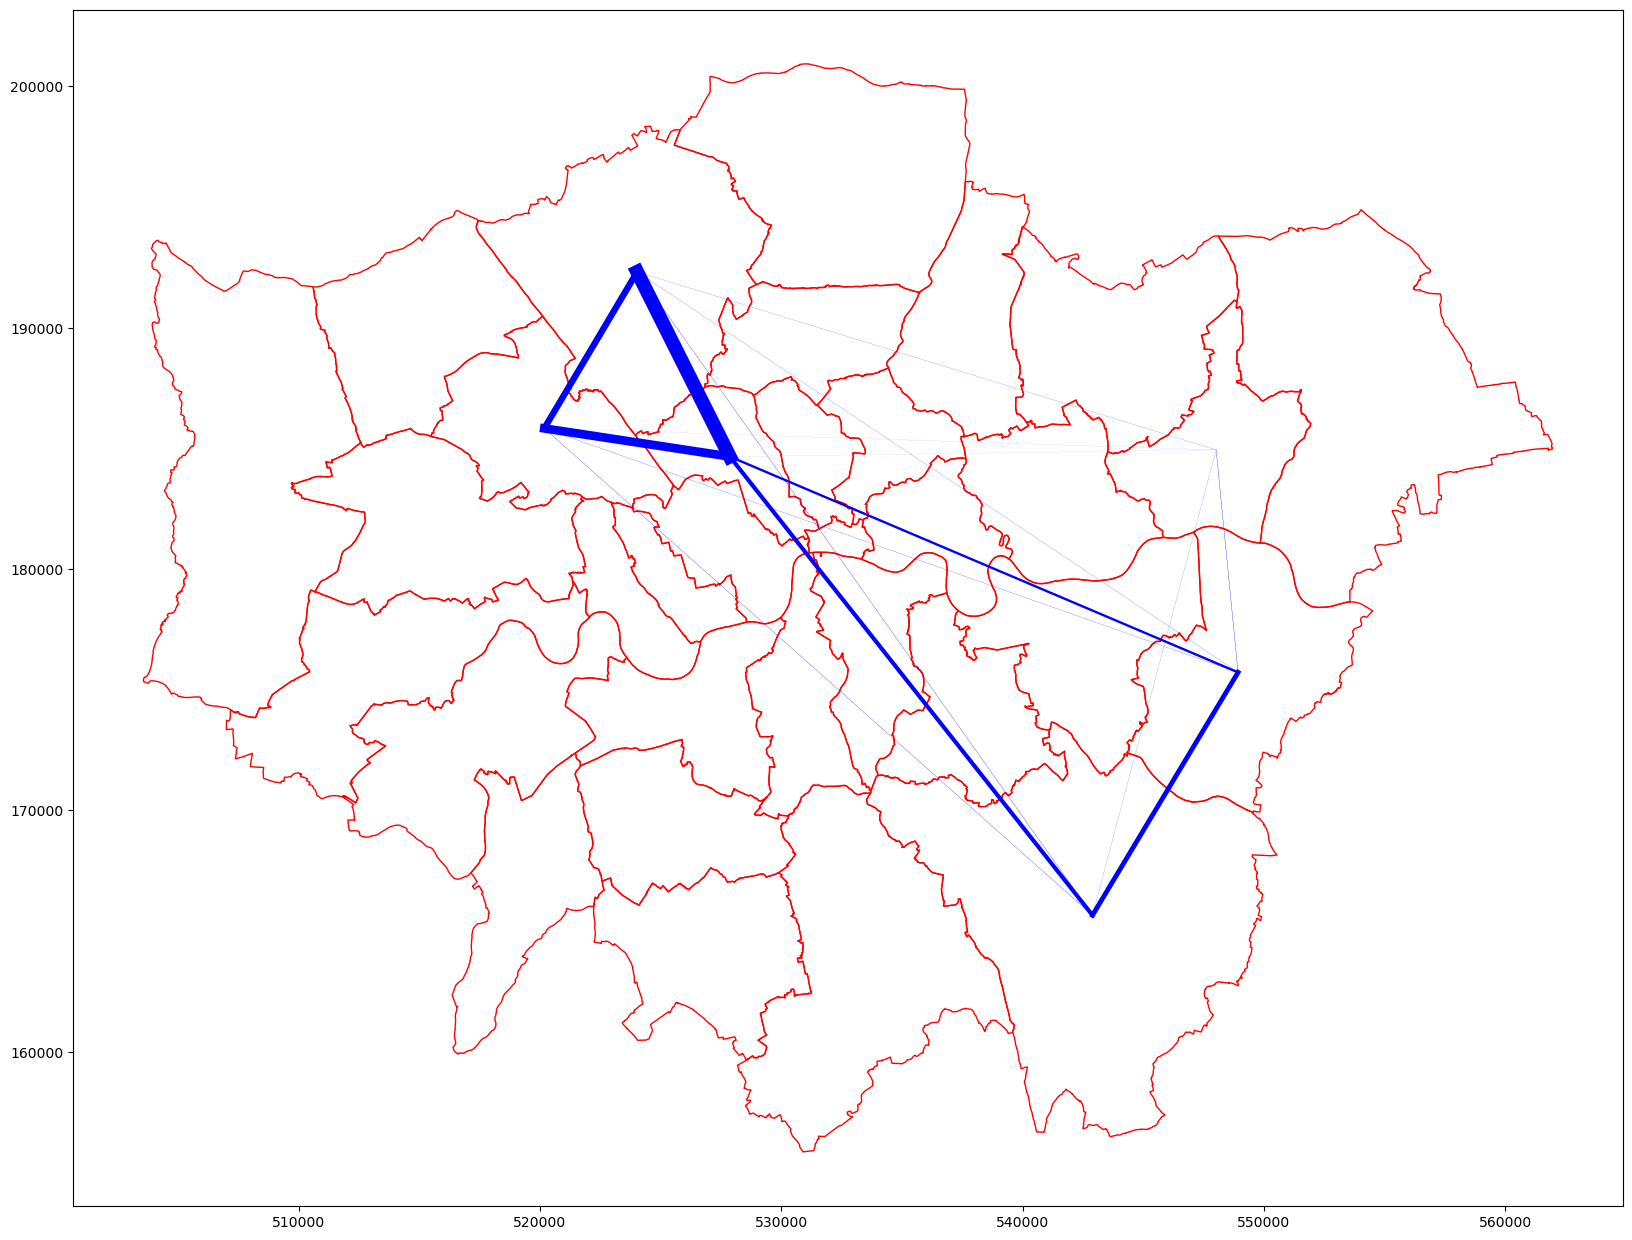

In [656]:
#plot the base map
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")

#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the x coordinates
    x1 = [London[London["lad15cd"] == row["OrigCodeNew"]]["Centroids"].x, London[London["lad15cd"] == row["DestCodeNew"]]["Centroids"].x]
    #get the y coordinates
    y1 = [London[London["lad15cd"] == row["OrigCodeNew"]]["Centroids"].y, London[London["lad15cd"] == row["DestCodeNew"]]["Centroids"].y]
    #plot the line between the x and y coordinates with width reflecting the number of flows
    plt.plot(x1, y1, linewidth = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*10, color = "Blue")
    
#be careful when working with large amounts of data

Or, if you really want to be cool - on a leaflet map. See [here](https://python-visualization.github.io/folium/) for more details on this.

In [657]:
import folium

#set the base map to locate on London
my_map =folium.Map(location = [51.5, 0.1278], zoom_start = 10)

#transform to WGS84
London_WGS = London.to_crs("EPSG:4326")
London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)

# style_function = lambda x: {"fillColor": "blue",
#                            "lineColor":"black",
#                            "opacity":0.2}

# folium.GeoJson(London_WGS["geometry"],
#               style_function = style_function).add_to(my_map)

#plot in leaflet
#This is done using the folium library
#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the first set of coordinates
    x1 = [London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["x"].values[0],
       London_WGS[London_WGS["lad15cd"]==row["OrigCodeNew"]]["y"].values[0]]
    #get the second set of coordinates
    x2 = [ London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["x"].values[0],
           London_WGS[London_WGS["lad15cd"]==row["DestCodeNew"]]["y"].values[0]]
    #create a list of the coordinates
    coords = [x1, x2]
    #add a polyline with size reflective of the number of people
    folium.vector_layers.PolyLine(coords, 
                                  weight = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*20, 
                                  opacity = 0.5
                                 ).add_to(my_map)
                                
#plot the map                                
my_map

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1632370315.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1632370315.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)


In [659]:
cdatasub.head(1)

,OrigCodeNew,DestCodeNew,TotalNoIntra,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",...,LAD24NM_x,LAD24NM_y,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist,OrigCode4,DestCode4
0,E09000003,E09000002,144,E41000294,E41000293,144,0,15,15,6,...,Barking And Dagenham,Barnet,159000,18700,56000,16200,0.0,0.0,00AC,00AB


In [664]:
import numpy as np
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="OrigBorough", columns = "DestBorough",
                            aggfunc=np.sum, margins=True)
cdatasubmat

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1782780763.py:3: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1782780763.py:3: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1782780763.py:3: FutureWarning: The provided callable <function sum at 0x000001CEC

DestBorough,Barking And Dagenham,Barnet,Bexley,Brent,Bromley,Camden,All
OrigBorough,,,,,,,
Barnet,144.0,NaN,42.0,5908.0,91.0,14006.0,20191
Bexley,323.0,131.0,NaN,161.0,4846.0,2391.0,7852
Brent,56.0,6268.0,37.0,NaN,84.0,8735.0,15180
Bromley,135.0,209.0,2962.0,199.0,NaN,4145.0,7650
Camden,51.0,1918.0,47.0,1677.0,65.0,NaN,3758
All,709.0,8526.0,3088.0,7945.0,5086.0,29277.0,54631


In [665]:
boroughs = sorted(cdata["OrigBorough"].unique())

In [666]:
cdatasubmat = cdatasubmat.reindex(
    index=boroughs,
    columns=boroughs,
    fill_value=0
)

In [667]:
cdatasubmat

DestBorough,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,...,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth
OrigBorough,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,42.0,5908.0,91.0,14006.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bexley,131.0,NaN,161.0,4846.0,2391.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent,6268.0,37.0,NaN,84.0,8735.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bromley,209.0,2962.0,199.0,NaN,4145.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Camden,1918.0,47.0,1677.0,65.0,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Croydon,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ealing,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enfield,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Greenwich,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we have set everything up its

## Modellin' Time!

In explaining how to run and calibrate spatial interaction models in Python, Mike Batty's notation will be used for spatial interaction models. An alternative for this would be using Taylor Oshan's notation in his excellent primer on interaction models in Python. The paper is well worth a read and can be found [here](http://openjournals.wu.ac.at/region/paper_175/175.html)

Below is the classic multiplicate gravity model:

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

This gravity model can be written in the form more familiar from [Wilson's 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) 

\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

<b>This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversely proportional to the distance between them.
    
As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

### $T_{ij}$ - Flow Matrix
$T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.



![Example of a flow matrix](./Images/Example_Flow_Matrix.PNG)


Using the above dummy example, we can see that 210 people go from Islington to Westminster. To practice matrix notation, $T_{4,5}$ would be the result of the flows from Hackney (row 4) to Lambeth (column 5), which is 80.



### $O_{i}$ - Origin Matrix
$O_{i}$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called Oi1_origpop) and a vector of origin average salaries (which I have called Oi2_origsal) in 2001



![Example of a flow matrix](./Images/Origin_Population_Example.PNG)

The dummy example above shows an example of the borough populations in London.


### $D_{j}$ - Destination Matrix
$D_{j}$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called Dj1_destpop) and a vector of destination average salaries (which I have called Dj2_destsal) in 2001



![Example of a flow matrix](./Images/Destination_Salary_Example.PNG)

The dummy example above shows an example of the average salary in each borough in London.


### $d_{ij}$ - Cost Matrix
$d_{ij}$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is the distance and it is called ‘dist’ in our dataset.

![Example of a flow matrix](./Images/Distance_Matrix_Example.PNG)

The dummy example above shows an example of the distance between the centroids in each borough in London in km.


### $k$, $\alpha$, $\gamma$ and $\beta$ - Model Parameters

- $k$, $\alpha$, $\gamma$ and $β$ are all the model parameters to be estimated

$k$ is a constant of proportionality. Given that all flows estimated by the model will sum to any observed flow data used to calibrate the parameters:

\begin{equation} \tag{3}
k = \frac{T}{\sum_i \sum_j O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}}
\end{equation}

and $T$ is the sum of our matrix of observed flows or:

\begin{equation} \tag{4}
T= \sum_i \sum_j T_{ij}
\end{equation}

In English, this is just the sum of all observed flows divided by the sum of all of the other elements in the model.

It is critically important to have k in your model as your predicted flows could be vastly different e.g. 10 times larger than the actual flows. k ensures that your predicted flows correspond to your observed flows. k doesn't impact your distribution of flows. It is important that you always conserve your flows when you run spatial interaction models!


## Estimating Model Parameters

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}


Now, it’s perfectly possible to produce some flow estimates by plugging some arbitrary or expected estimated values into our parameters. The parameters relate to the scaling effect / importance of the variables they are associated with. A simple example is considering a linear scale, taking $\alpha$ = 1 and $\gamma$ = 1

\begin{equation} \tag{2}
T_{ij} = k \frac{O_i  D_j}{ d_{ij}^\beta}
\end{equation}

To interpret the impact of this, if we increased the population at the origin by 1, we would expect the flows to increase by 1 unit. If we halved the salary at a destination, we would expect the flows to reduce by half. If we decided to assign $\gamma$ = 2,

\begin{equation} \tag{3}
T_{ij} = k \frac{O_i  D_j^2}{ d_{ij}^\beta}
\end{equation}

then halving the salary would result in a reduction in flows to that destination to reduce by 1/4. Initially, we are going to consider $\gamma$ = 1.


In Newton’s original gravity equation, $\beta$ = 2 where the influence of distance on flows follows a power law.

\begin{equation} \tag{4}
T_{ij} = k \frac{O_i  D_j}{ d_{ij}^2}
\end{equation}


This is an inversely proportional relationship, therefore an increase in distance will result in a reduction in total flows. Increasing the distance by 1 unit, will result in a reduction of $\frac{1}{1^{2}} = 1$ in flows, while doubling the distance will result in a decrease of $\frac{1}{2^{2}} = \frac{1}{4}$ in flows.

Let’s see if these parameters are a fair first guess (we’ll use the whole dataset in order to get a less messy picture)…


In [673]:
cdata.columns.tolist()

['OrigCode',
 'DestCode',
 'All categories: Method of travel to work',
 'Work mainly at or from home',
 'Underground, metro, light rail, tram',
 'Train',
 'Bus, minibus or coach',
 'Taxi',
 'Motorcycle, scooter or moped',
 'Driving a car or van',
 'Passenger in a car or van',
 'Bicycle',
 'On foot',
 'Other method of travel to work',
 'OrigBorough',
 'DestBorough',
 'LAD24NM_x',
 'DestCodeNew',
 'LAD24NM_y',
 'OrigCodeNew',
 'Oi1_origpop',
 'Oi2_origsal',
 'Dj1_destpop',
 'Dj2_destsal',
 'TotalNoIntra',
 'offset',
 'Dist',
 'OrigCode4',
 'DestCode4']

Text(0, 0.5, 'Total Flows')

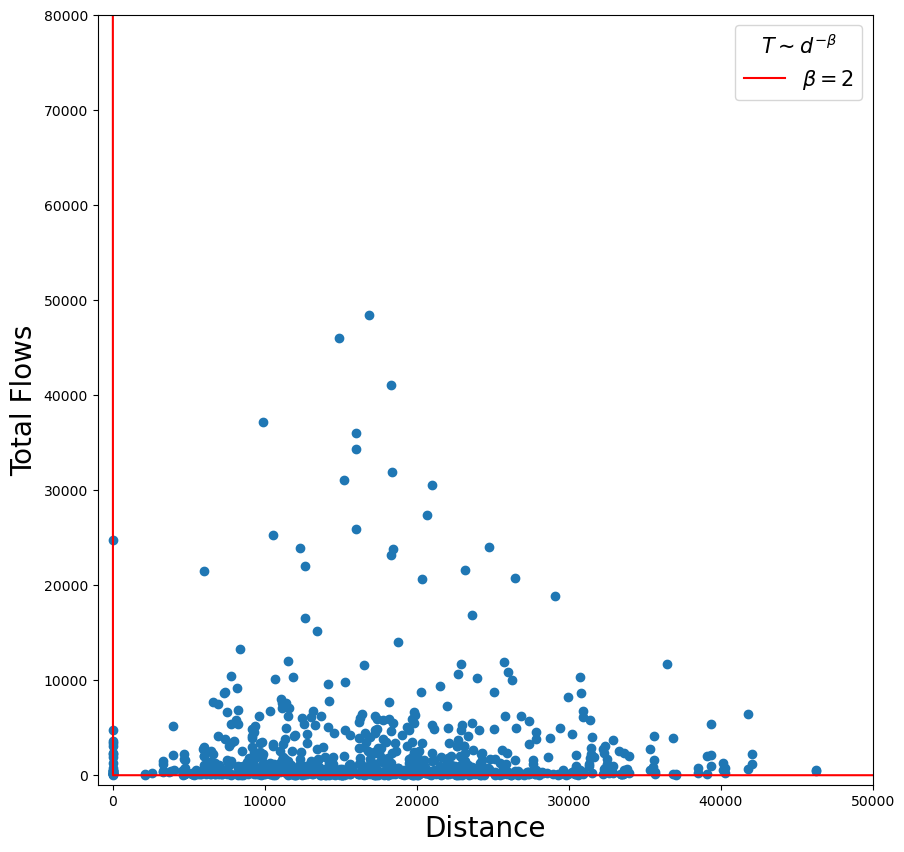

In [671]:
#first plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Dist"], y=cdata["All categories: Method of travel to work"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 80000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

We can see a roughly inverse proportional relationship with the data i.e. as distance increases the total flows decrease.

What about the origin and destination data

In [676]:
cdata.head(33)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,...,OrigCodeNew,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist,OrigCode4,DestCode4
0,E41000294,E41000293,144,0,15,15,6,1,2,95,...,E09000003,159000,18700,56000,16200,144,0.000000e+00,0.000000,00AC,00AB
30,E41000294,E41000323,567,0,315,47,41,0,12,121,...,E09000003,159000,18700,143000,21700,567,0.000000e+00,10442.423012,00AC,00BJ
29,E41000294,E41000322,585,0,101,21,40,1,13,381,...,E09000003,159000,18700,99000,16600,585,0.000000e+00,4013.087046,00AC,00BH
28,E41000294,E41000321,3461,0,2278,384,82,2,57,553,...,E09000003,159000,18700,76000,19100,3461,0.000000e+00,17948.340108,00AC,00BG
27,E41000294,E41000320,68,0,19,24,7,0,2,15,...,E09000003,159000,18700,98000,17600,68,0.000000e+00,4648.804431,00AC,00BF
26,E41000294,E41000319,2357,0,1650,317,90,3,40,186,...,E09000003,159000,18700,97000,16900,2357,0.000000e+00,17231.728599,00AC,00BE
25,E41000294,E41000318,383,0,103,40,31,0,17,155,...,E09000003,159000,18700,94000,23400,383,0.000000e+00,14108.681434,00AC,00BD
24,E41000294,E41000317,338,0,70,5,4,1,6,236,...,E09000003,159000,18700,118000,17200,338,0.000000e+00,9126.652017,00AC,00BC
23,E41000294,E41000316,601,0,190,50,45,1,7,272,...,E09000003,159000,18700,88000,15300,601,0.000000e+00,13713.985890,00AC,00BB
21,E41000294,E41000314,210,0,71,23,31,0,1,59,...,E09000003,159000,18700,113000,18000,210,0.000000e+00,6974.964366,00AC,00AZ


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1082451275.py:13: SyntaxWarning: invalid escape sequence '\s'
  ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)


Text(0, 0.5, 'Total Flows')

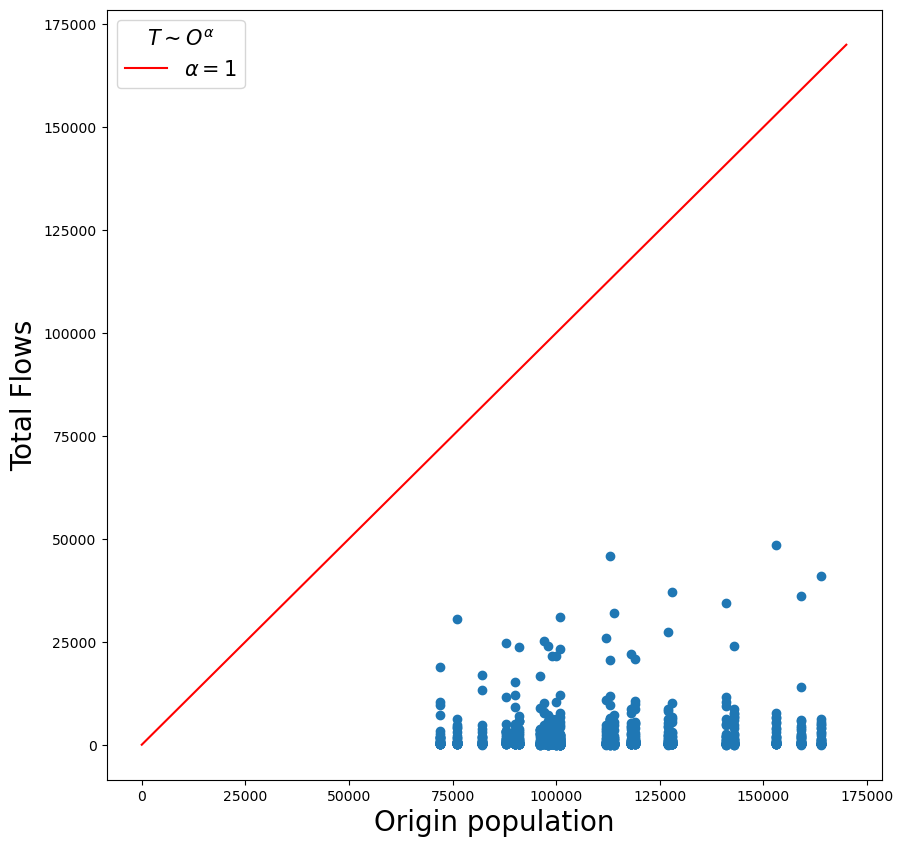

In [678]:
#Let us now look at the behaviour of the flows with respect to the population at the origin denoted by O
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Oi1_origpop"], y=cdata["All categories: Method of travel to work"])
#line plot
line = np.arange(0.0002, 170_000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\alpha=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Looking at the general trend of origin population and total flows, we can see that as origin population increases, then total flows increase. However, it is clear that the constant currently does capture this trend that well as the predicted total flows for the given parameter are far from the actual data values.

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\1248293207.py:13: SyntaxWarning: invalid escape sequence '\s'
  ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)


Text(0, 0.5, 'Total')

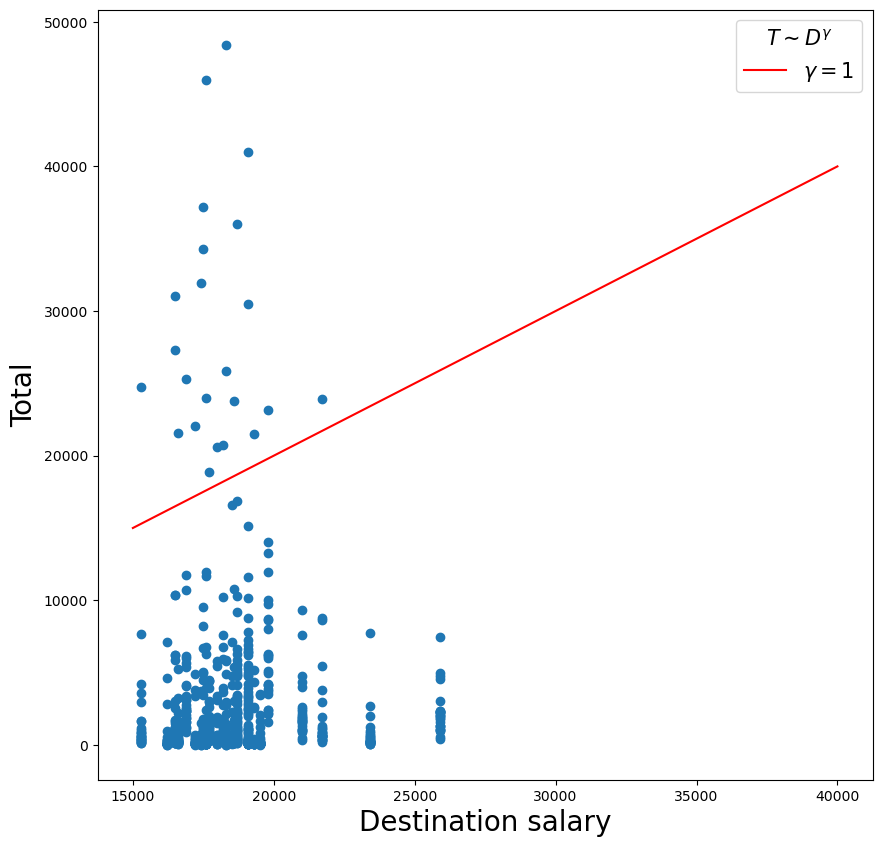

In [679]:
#Now let us look at the behaviour of the flows with respect to the salaries at destination denoted by D
# and then fit a model line  T ~ D^gamma. We will fit a line for gamma=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Dj2_destsal"], y=cdata["All categories: Method of travel to work"])
#line plot
line = np.arange(15_000, 40000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\gamma=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination salary", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)

Okay, so it looks like we are not far off (well, destination salary doesn't look too promising as a predictor, but we'll see how we get on ...), so let's see what flow estimates with these starting parameters look like.

In [680]:
#set up some variables to hold our parameter values in:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdatasub["All categories: Method of travel to work"])

Now we can create some flow estimates using equation the equation below... Begin by applying the parameters to the variables:
\begin{equation}
T_{ij} = k \frac{O_i  D_j}{ d_{ij}^2}
\end{equation}

In [685]:
Oi1_alpha = cdatasub["Oi1_origpop"]**alpha
Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = (cdatasub["Dist"] + 1e-6) ** (beta * -1)
T1 = Oi1_alpha*Dj2_gamma*dist_beta
k = T2/sum(T1)

Then, just as in Equation 2 above, just multiply everything together to get your flow estimates.

\begin{equation}
k = \frac{T}{\sum_i \sum_j O_i  D_j  d_{ij}^{-2}}
\end{equation}

where

\begin{equation}
T= \sum_i \sum_j T_{ij}
\end{equation}

In [686]:
cdatasub.head(30)

,OrigCodeNew,DestCodeNew,TotalNoIntra,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",...,LAD24NM_y,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist,OrigCode4,DestCode4,unconstrainedEst1
0,E09000003,E09000002,144,E41000294,E41000293,144,0,15,15,6,...,Barnet,159000,18700,56000,16200,0.0,0.000000,00AC,00AB,NaN
2,E09000003,E09000004,42,E41000294,E41000295,42,0,5,2,4,...,Barnet,159000,18700,112000,18300,0.0,13935.493781,00AC,00AD,0.0
3,E09000003,E09000005,5908,E41000294,E41000296,5908,0,359,88,1260,...,Barnet,159000,18700,127000,16500,0.0,17359.785331,00AC,00AE,0.0
4,E09000003,E09000006,91,E41000294,E41000297,91,0,34,23,8,...,Barnet,159000,18700,164000,19100,0.0,13119.643266,00AC,00AF,0.0
5,E09000003,E09000007,14006,E41000294,E41000298,14006,0,7338,1273,1515,...,Barnet,159000,18700,101000,19800,0.0,18740.607285,00AC,00AG,0.0
32,E09000004,E09000003,131,E41000295,E41000294,131,0,23,48,7,...,Bexley,112000,18300,159000,18700,0.0,4722.485290,00AD,00AC,0.0
34,E09000004,E09000005,161,E41000295,E41000296,161,0,35,45,17,...,Bexley,112000,18300,127000,16500,0.0,0.000000,00AD,00AE,NaN
35,E09000004,E09000006,4846,E41000295,E41000297,4846,0,20,236,793,...,Bexley,112000,18300,164000,19100,0.0,25100.158362,00AD,00AF,0.0
36,E09000004,E09000007,2391,E41000295,E41000298,2391,0,160,1867,65,...,Bexley,112000,18300,101000,19800,0.0,9264.794305,00AD,00AG,0.0
31,E09000004,E09000002,323,E41000295,E41000293,323,0,15,23,18,...,Bexley,112000,18300,56000,16200,0.0,9520.742921,00AD,00AB,0.0


In [687]:
#run the model and store of the new flow estimates in a new column
cdatasub["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

54631

We can turn this into a matrix to look at the predictors flows we have produced. This is the total flows for our observed flows that are predicted flows should also equal.

In [689]:
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="OrigBorough", columns = "DestBorough",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\936756482.py:1: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\936756482.py:1: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\936756482.py:1: FutureWarning: The provided callable <function sum at 0x000001CE

DestBorough,Barking And Dagenham,Barnet,Bexley,Brent,Bromley,Camden,All
OrigBorough,,,,,,,
Barnet,31809.0,NaN,0.0,0.0,0.0,0.0,31809
Bexley,0.0,0.0,NaN,22822.0,0.0,0.0,22822
Brent,0.0,0.0,0.0,NaN,0.0,0.0,0
Bromley,0.0,0.0,0.0,0.0,NaN,0.0,0
Camden,0.0,0.0,0.0,0.0,0.0,NaN,0
All,31809.0,0.0,0.0,22822.0,0.0,0.0,54631


How do the flow estimates compare to the original flows?

In [690]:
cdatasubmat

DestBorough,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,...,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth
OrigBorough,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,42.0,5908.0,91.0,14006.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bexley,131.0,NaN,161.0,4846.0,2391.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent,6268.0,37.0,NaN,84.0,8735.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bromley,209.0,2962.0,199.0,NaN,4145.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Camden,1918.0,47.0,1677.0,65.0,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Croydon,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ealing,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enfield,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Greenwich,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## How good is my model?

So looking at the two matrices above you can see that in some cases the flow estimates aren't too bad (Barking and Dagenham to Barnet for example, but in others they are pretty rubbish (Camden to the City of London?). Whilst it's OK to eyeball small flow matrics like this, when you have much larger matrices we need another solution ...

### Testing the "Goodness-of-fit"

Yes, that’s what it’s called - I know, it doesn’t sound correct, but goodness-of-fit is the correct term for checking how well your model estimates match up with your observed flows.

So how do we do it?

Well… there are a number of ways but perhaps the two most common are to look at the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). You’ve probably come across $r^2$ before if you have fitted a linear regression model, but you may not have come across RMSE. There are other methods and they all do more or less the same thing, which is essentially to compare the modelled estimates with the real data. $r^2$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue that it is better for comparing changes to the same model. Here we’ll do both…

### R-Squared
 
$r^2$ is the square of the correlation coefficient, $r$

For our sample data, we can calculate this very easily using a little function.


In [692]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

CalcRSqaured(cdatasub["All categories: Method of travel to work"], cdatasub["unconstrainedEst1"])

np.float64(0.030211812063842495)

Using this function we get a value of around 0.50, or around 50%. This tells us that our model accounts for about 50% of the variation of flows in the system. Not bad, but not brilliant either.

### Root Mean Squared Error (RMSE)

We can use a similar simple function to calcualte the RMSE for our data

In [693]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

CalcRMSE(cdatasub["All categories: Method of travel to work"], cdatasub["unconstrainedEst1"])

8774.402

The figure that is produced by the RMSE calcaultion is far less intuitive than the $r^2$ and this is mainly because it very much depends on things like the units the data are in and the volume of the data. It can't be used to compared different models run using different data sets. However, it is good for assessing whether changes to the model result in improvements. The closer to 0 the RMSE value, the better the model.

So how can we start to improve our fit...?

## Improving our model: 1 -  calibrating parameters

### (This bit might take a while but stick with it)

Now, the model we have run above is probably the most simple spatial interaction model we could have run and the results aren’t terrible, but they’re not great either.

One way that we can improve the fit of the model is by calibrating the parameters on the flow data that we have.

The traditional way that this has been done computationally is by using the goodness-of-fit statistics. If you have the requisite programming skills, you can write a computer algorithm that iteratively adjusts each parameter, runs the model, checks the goodness-of-fit and then starts all over again until the goodness-of-fit statistic is maximised.

This is partly why spatial interaction modelling was the preserve of specialists for so long as acquiring the requisite skills to write such computer programmes can be challenging!

However, since the early days of spatial interaction modelling, a number of useful developments have occurred…

The mathematically minded among you may have noticed that if you take the logarithms of both sides of Equation 2, you end up with the following equation:

\begin{equation} \tag{5}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij}
\end{equation}

where $K= \ln k$. Those of you who have played around with regression models in the past will realise that this is exactly that - a regression model.

And if you have played around with regression models you will be aware that there are various pieces of software available to run regressions (such as Python) and calibrate the parameters for us, so we don't have to be expert programmers to do this - yay!

Now there are a couple of papers that are worth reading at this point. Perhaps the best is [Flowerdew and Aitkin (1982)](http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9787.1982.tb00744.x/abstract), title “A METHOD OF FITTING THE GRAVITY MODEL BASED ON THE POISSON DISTRIBUTION”.

One of the key points that Flowerdew and Aitkin make is that the model in equation 5 (known as a log-normal model) has various problems associated with it which means that the estimates produced might not be reliable. If you'd like to know more about these, read that paper (and also Wilson's 1971 paper), but at this point it is worth knowing that the way around many of these is to re-specify the model, not as a log-normal regression, but as a Poisson or negative binomial regression model.

## Poisson regression

The main theory (for non-experts like me anyway) behind the Poisson regression model is that the sorts of flows that spatial interaction models deal with (such as migration or commuting flows) relate to non-negative integer counts (you can’t have negative people moving between places and you can’t - normally, if they are alive - have fractions of people moving either).

As such, the continuous (normal) probability distributions which underpin standard regression models don’t hold. However, the discrete probability distributions such as the Poisson distribution and the negative binomial distribution (of which the Poisson distribution is a special case - wikipedia it) do hold and so we can use these associations to model our flows.

At this point, it’s probably worth you looking at what a Poisson disribution looks like compared to a normal distribution, if you are not familiar.

Here’s a normal distribution:

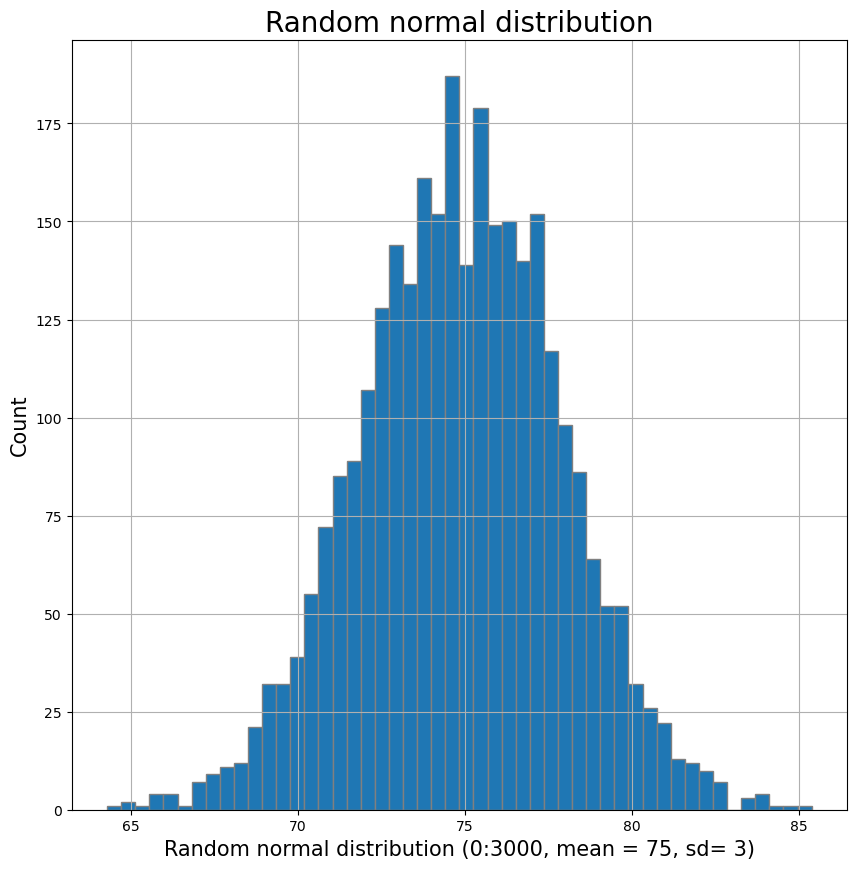

In [694]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.normal(loc = 75, scale= 3, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random normal distribution (0:3000, mean = 75, sd= 3)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random normal distribution", fontsize = 20)
plt.grid(True)

Now here’s a Poisson distribution with the same mean:

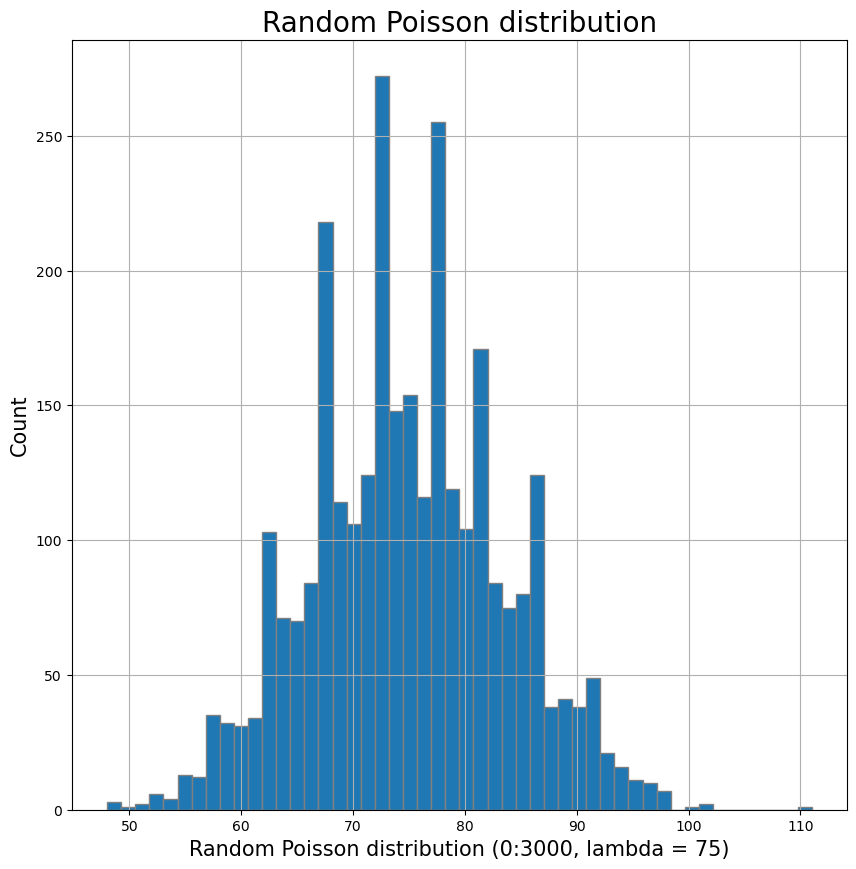

In [695]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 75, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random Poisson distribution (0:3000, lambda = 75)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

Looks kind of similar doesn’t it! The thing with the Poisson distribution is, when the mean (λ - lambda) changes, so does the distribution. As the mean gets smaller (and this is often the case with flow data where small flows are very likely - have a look at the ‘Total’ column in your cdata dataframe, lots of small numbers aren’t there?) the distribution starts to look a lot more like a skewed or log-normal distrbution. The key thing is it’s not - it’s a Poisson distribution. Here’s a similar frequency distribution with a small mean:

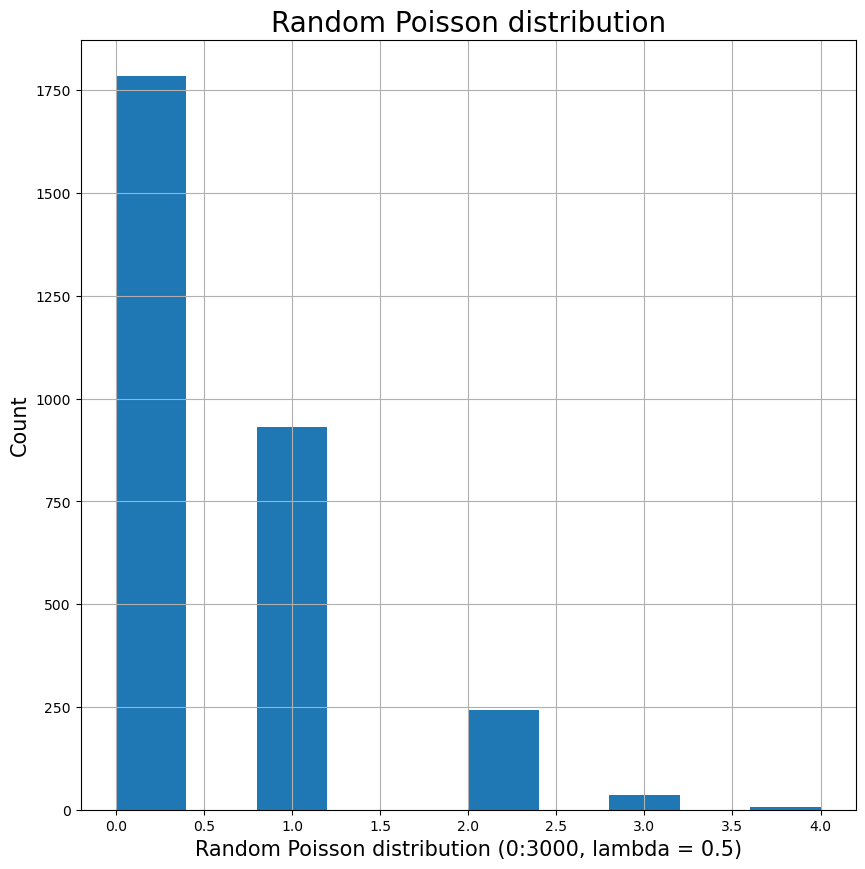

In [696]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 0.5, size = 3000))
plt.xlabel("Random Poisson distribution (0:3000, lambda = 0.5)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

As far as we’re concerned, what this means is that if we are interested in all flows between all origins and destinations in our system, these flows will have a mean value of $\lambda_{ij}$ and this will dictate the distribution. Here’s what the distrbution of our flows looks like:

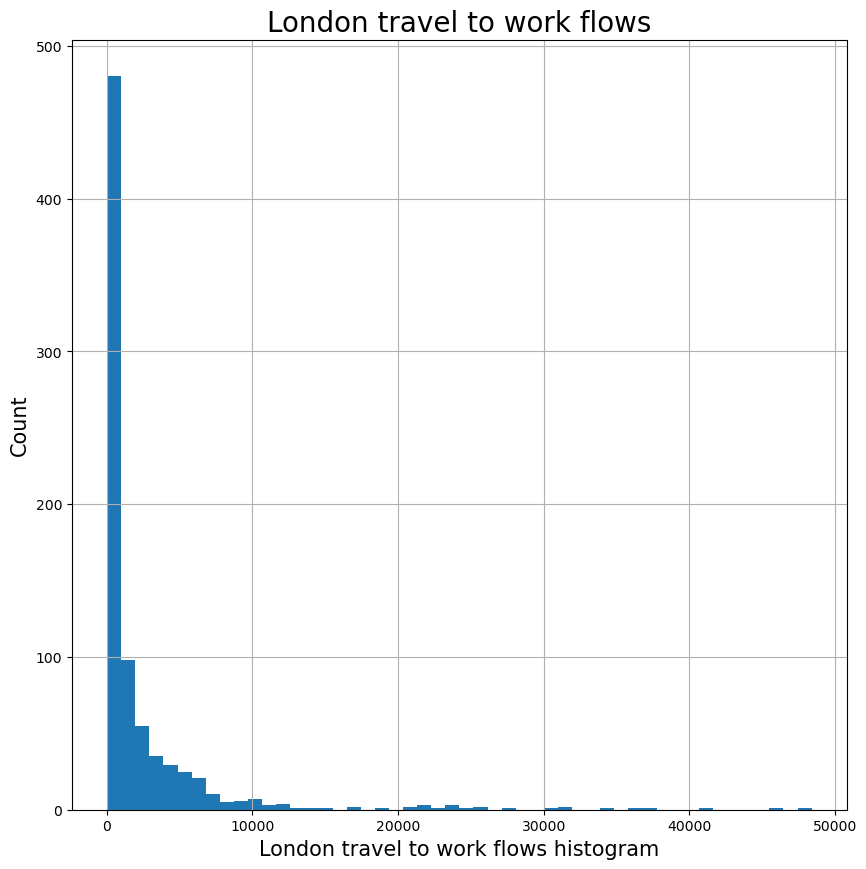

In [697]:
plt.subplots(figsize=(10,10))

plt.hist(cdata["All categories: Method of travel to work"], histtype="stepfilled" , bins = 50)
plt.xlabel("London travel to work flows histogram", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("London travel to work flows", fontsize = 20)
plt.grid(True)

### Mmmm, Poissony!

So, what does all of this mean for our spatial interaction model?

Well the main thing it means is that Equation 5, for most sorts of spatial interaction models where we are modelling flows of people or whole things, is not correct.

By logging both sides of the equation in Equation 5, we are trying to get a situation where our Tij flows can be modelled by using the values of our other variables such as distance, by using a straight line a bit like this:

Text(0, 0.5, 'log(All categories: Method of travel to work)')

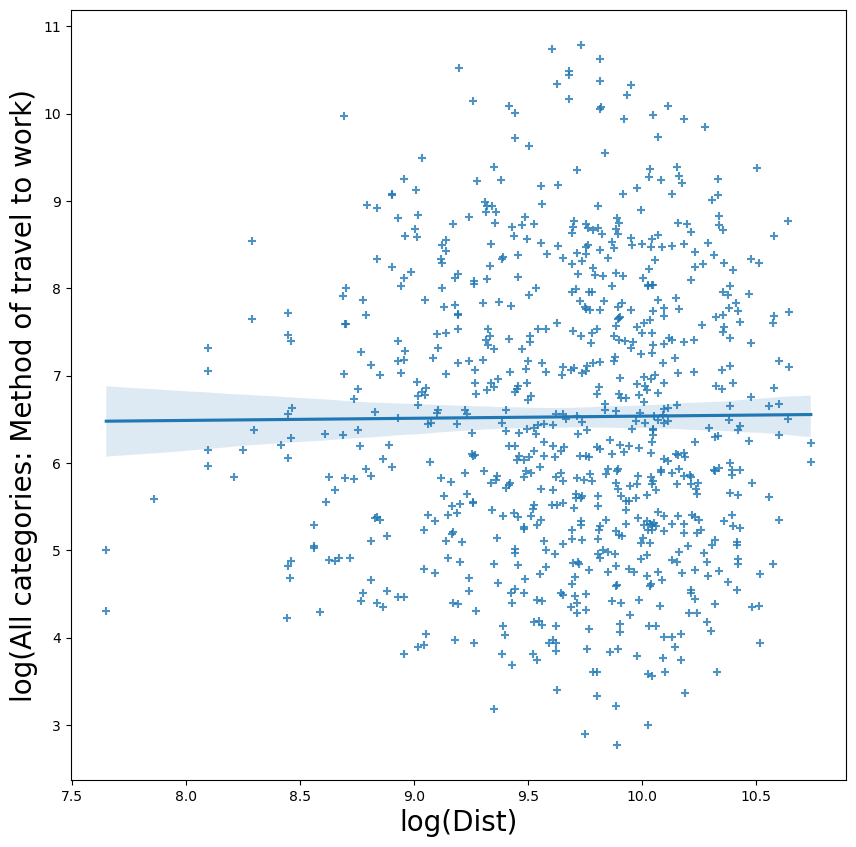

In [698]:
#subset the dataframe to the flows we want
cdata_flows = cdata[["All categories: Method of travel to work", "Dist"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["Dist"])
y = np.log(cdata_flows["All categories: Method of travel to work"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)
ax.set_xlabel("log(Dist)", fontsize = 20)
ax.set_ylabel("log(All categories: Method of travel to work)", fontsize = 20)

If you compare this graph with the graph above (the first scatter plot we drew), it’s exactly the same data, but clearly by logging both the total and distance, we can get a bit closer to being able to fit a model estimate using a straight line.

What the Poisson distribution means is that the y variable in our model corresponds to the expected value, as we will show in the equation (6) below, and the equation can be linearised and modelled in a similar way to the blue line above.

### The Poisson Regression Spatial Interaction Model

So, we can now re-specify Equation 5 as a Poisson Regression model. Basically, we are assuming that the flows follow a Poisson distribution, such that the expected value $\lambda_{ij}$ verifies:

\begin{equation} \tag{6}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

What this model says is that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model. 

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimated of $k$, $\alpha$, $\gamma$ and $\beta$ - or put another way, we can use the rgeression model to calibrate our parameters.

So, let's have a go at doing it!

It is very straightforward to run a Poisson regression model in Python using the `glm` function in the Statsmodel.api library. In practical terms, running a GLM model is no different to running a standard regression model using `lm`. If you want to find more details about this you can visit the statsmodel api documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM) and [here](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html) or for more information about the Poisson regression application you can read other articles on the internet such as this [medium article](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958). If you delve far enough into the depths of what GLM does, you will find that the parameters are calibrated though an ‘iteratively re-weighted least squares’ algorithm. This algorithm does exactly the sort of job I described earlier, it fits lots of lines to the data, continually adjusting the parameters and then seeing if it can minimise the error between the observed and expected values using some goodness-of-fit measure.

These sorts of algorithms have been around for years and are very well established so it makes sense to make use of them rather than trying to re-invent the wheel ourselves. So here we go…

In [720]:
cdata["Dist_clean"] = np.where(
    cdata['Dist'].astype(float) <= 0,
    1e-6,
    cdata['Dist'].astype(float)
)

In [721]:
cdata.head(3)

,OrigCode,DestCode,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,...,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist,OrigCode4,DestCode4,Dist_clean
0,E41000294,E41000293,144,0,15,15,6,1,2,95,...,159000,18700,56000,16200,144,0.0,0.000000,00AC,00AB,0.000001
30,E41000294,E41000323,567,0,315,47,41,0,12,121,...,159000,18700,143000,21700,567,0.0,10442.423012,00AC,00BJ,10442.423012
29,E41000294,E41000322,585,0,101,21,40,1,13,381,...,159000,18700,99000,16600,585,0.0,4013.087046,00AC,00BH,4013.087046


In [723]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#take the variables and produce logarithms of them
x_variables = ["Oi1_origpop", "Dj2_destsal", "Dist_clean"]
log_x_vars = []
for x in x_variables:
    cdata[f"log_{x}"] = np.log(cdata[x])
    log_x_vars.append(f"log_{x}")

#create the formula
formula = "Q('All categories: Method of travel to work') ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist_clean"


#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdata, 
                  family=sm.families.Poisson()).fit()


It’s a simple as that - runs in a matter of milliseconds. You should be able to see how the `glm` code corresponds to Equation 6.

`Total` = $T_{ij}$ = $\lambda_{ij}$

`~` means ‘is modelled by’

`log_Oi1_origpop` = $\ln O_i$

`log_Dj2_destsal` = $\ln D_j$

`log_dist` = $\ln d_{ij}$

`family=sm.families.Poisson()`means that we are using a Poisson regression model (the link is always log with a Poisson model) where the left-hand side of the model equation is logarithmically linked to the variables on the right-hand side.

So what comes out of the other end?

Well, we can use the `summary()` function to have a look at the model parameters:

In [724]:
#extract the summary of the constrained model
print(uncosim.summary())

                               Generalized Linear Model Regression Results                               
Dep. Variable:     Q('All categories: Method of travel to work')   No. Observations:                  806
Model:                                                       GLM   Df Residuals:                      802
Model Family:                                            Poisson   Df Model:                            3
Link Function:                                               Log   Scale:                          1.0000
Method:                                                     IRLS   Log-Likelihood:            -2.1819e+06
Date:                                           Tue, 20 Jan 2026   Deviance:                   4.3570e+06
Time:                                                   20:21:47   Pearson chi2:                 9.02e+06
No. Iterations:                                                6   Pseudo R-squ. (CS):              1.000
Covariance Type:                              

We can see from the summary that the Poisson regression has calibrated all 4 parameters for us and these appear under the ‘estimate’ column:

$K$ (intercept) = -15.8084. Recall $K=\ln k$, hence $k$ can NEVER be negative!

$\alpha$ = 1.7558

$\gamma$ = 1.6472

and $\beta$ = 1.4079 recall in equation (6) there is a negative sign in front of $\beta$. 

We can also see from the other outputs that all variables are highly significant (P>|z| < 0.01), with the z-scores revealing that distance has the most influence on the model (as we might have expected from the scatter plots we produced earlier which showed that distance had by far the strongers correlation with commuting flows).

These parameters are not too far away from our initial guesses of $\alpha$ = 1, $\gamma$ = 1 and $\beta$ = 2, but how do the estimates compare?

One way to calculate the estimates is to plug all of the parameters back into Equation 6 like this:

In [725]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdatasub["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdatasub["log_Oi1_origpop"] 
                                       + gamma*cdatasub["log_Dj2_destsal"] 
                                       - beta*cdatasub["log_Dist_clean"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdatasub["fitted"] = predictions_summary_frame["mean"]

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\2994363602.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K = uncosim.params[0]
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\2994363602.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = uncosim.params[1]
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\2994363602.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = uncosim.params[2]
C:\Us

In [726]:
uncosim.mu

array([2556.45958249, 3147.19876742, 2999.32162751, 3097.58058378,
       3029.68484275, 3038.70786622, 3190.84331795, 3033.34699894,
       2987.56670337, 3048.93336608, 3076.38745052, 3087.18740895,
       3212.49246828, 3089.47979304, 3035.17924022, 3067.13678002,
       3055.181974  , 3063.45095515, 3071.68841914, 3027.64438498,
       3090.74003081, 3115.79863997, 3052.53853712, 3055.70612346,
       3084.96261053, 3081.2965559 , 3051.19997639, 3113.57538208,
       3082.93428686, 3086.28807479, 3054.29771303, 2464.1022107 ,
       2483.11851371, 2645.23986208, 2529.66517834, 2489.68951998,
       2490.92036095, 2426.8362182 , 2445.85941293, 2597.05916183,
       2459.12200395, 2520.15719898, 2453.98312226, 2568.39517865,
       2466.05634144, 2477.41507457, 2508.31273649, 2508.59749201,
       2477.75665077, 2490.84000842, 2076.90261313, 2515.33869049,
       2511.64016239, 2500.60719507, 2435.45453504, 2479.42382052,
       2477.74110099, 2505.66184212, 2490.36000835, 2547.78751

In [727]:
#round the numbers so that we don't get a half of a person
cdatasub["unconstrainedEst2"] = round(cdatasub["unconstrainedEst2"], 0)
#convert to integers
cdatasub["unconstrainedEst2"] = cdatasub["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst2"])

67594

In [729]:
#turn it into a little matrix and have a look at your handy work
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="OrigBorough", columns = "DestBorough",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\586670823.py:2: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\586670823.py:2: FutureWarning: The provided callable <function sum at 0x000001CEC6E20680> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="OrigBorough", columns = "DestBorough",
C:\Users\Owen Hughes\AppData\Local\Temp\ipykernel_22548\586670823.py:2: FutureWarning: The provided callable <function sum at 0x000001CE

DestBorough,Barking And Dagenham,Barnet,Bexley,Brent,Bromley,Camden,All
OrigBorough,,,,,,,
Barnet,2556.0,NaN,3072.0,3028.0,3091.0,3116.0,14863
Bexley,2435.0,2478.0,NaN,2077.0,2515.0,2512.0,12017
Brent,2631.0,2689.0,2694.0,NaN,2701.0,2728.0,13443
Bromley,3077.0,3156.0,3133.0,3080.0,NaN,3164.0,15610
Camden,2296.0,2360.0,2340.0,2311.0,2354.0,NaN,11661
All,12995.0,10683.0,11239.0,10496.0,10661.0,11520.0,67594


In [730]:
#compare it to the actual flows
cdatasubmat

DestBorough,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,...,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth
OrigBorough,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,42.0,5908.0,91.0,14006.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bexley,131.0,NaN,161.0,4846.0,2391.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent,6268.0,37.0,NaN,84.0,8735.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bromley,209.0,2962.0,199.0,NaN,4145.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Camden,1918.0,47.0,1677.0,65.0,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Croydon,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ealing,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enfield,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Greenwich,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see here that some of the estimates have improved such as Barking and Dagenham to Barnet is now even closer and is within 10% of the actual flow, while the Barking and Dagenham to Bexley predicted flow has converged but is still far out.

Therefore the $1,000,000 question is - has calibrating the parameters improved the model...?

In [731]:
CalcRSqaured(cdatasub["All categories: Method of travel to work"], cdatasub["unconstrainedEst2"])

np.float64(0.08578754896495103)

In [732]:
CalcRMSE(cdatasub["All categories: Method of travel to work"], cdatasub["unconstrainedEst2"])

3359.597

## Yes indeedy do!!

The $r^2$ has improved from 0.50 to 0.67 and the RMSE has reduced from 2503.35 to 1892.62 so by calibrating our parameters using the Poisson Regression Model, we have markedly improved our model fit.

But we can do even better. We have just been playing with the unconstrained model, by adding constraints into the model we can both improve our fit further AND start to do cool things like estimate transport trip distributions from known information about people leaving an area, or estimate the amount of money a shop is going to make from the available money that people in the surrounding area have to spend, or guess the number of migrants travelling between specific countries where we only know how many people in total leave one country and arrive in another.

We'll do all of this in part 2 of these sessions.


# Challenge to complete

It is recommended that you complete this challenge to show that you understand the purpose of this model and how it can be used.

We will repeat the steps above but for seven different boroughs of Croydon, Islington, Greenwich, Westminster, Hounslow, Lambeth and Ealing with the aim of seeing how the modelling results change with the new Boroughs and trying to understand why.

You can follow the comments in the code to complete this task. The code blocks are broken up for your convenience. Please complete the quiz in moodle, we will discuss the answers in the practical session. 

### 1) Extract the data for the seven boroughs

Extract the data for the seven boroughs into `cdatasub_new` dataframe.

In [51]:
#we can select seven random boroughs
to_match_upd = ['Croydon', 'Islington', 'Greenwich', 
                'Westminster', 'Hounslow', 
                'Lambeth', 'Ealing']

#subset the data by the 7 sample boroughs
#create cdatasub_new


#remove intrap-borough flows


#we now want to re-order so that OrigCodeNEw, DestCodeNew and 
#TotalNoIntra are the first three columns


#re index the columns


In [52]:
#check the head of the data


### 2) Plot the flows between these seven boroughs

Plot the flows between the seven boroughs in the same way we did before. You can simply just plot the non-interactive one. Think about how these flows are different to what you saw before.

In [53]:
#plot the London base map


#iterate over each pair in the cdatasub_new 
#dataframe to plot the interaction

    #get the x coordinates
    
    #get the y coordinates
    
    #plot the line between the x and y coordinates with width reflecting the number of flows
    
    
#be careful when working with large amounts of data

### 3) Show the flows in an updated matrix

Create a new matrix called `cdatasubmat_new` and examine the results. 

In [54]:
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well


### 4) Use the paramaters from the calibrated model above to estimate flows

Using the paramater values from the calibrated model above (alpha, gamma, beta and k). To calculate an estimate of flows for these boroughs.

In [55]:
#set up some variables to hold our parameter values in from 
#the previous model
alpha = 
gamma = 
beta = 
k = 
T2 = 

SyntaxError: invalid syntax (883934164.py, line 3)

In [ ]:
#estimate the values using these parameters
Oi1_alpha = 
Dj2_gamma = 
dist_beta = 
T1 = 
k = 

In [ ]:
#run the model to estimate the values 
#in the new dataframe

#convert to integers

#check that the sum of these estimates make sense


### 5) Evaluate the results using $R^2$ and $RMSE$ values

Print the results of the model in terms of the $R^2$ and $RMSE$ values. Show the pivot table of the results. Discuss why you get the values you do. Why do you get different results from the calibrated model?

In [ ]:
#show the paramater results

In [ ]:
#create a new matrix of the estimates


### 6) Implement the model on the new data

Use the new data to calibrate the model using Poisson regression just as we did before and print out the summary to see what it looks like. 

In [ ]:
#take the variables and produce logarithms of them


#create the formula

#run the regression


In [ ]:
#extract the summary of the constrained model


### 7) Print out the paramater values from the new model

Using the model instance print out the $\alpha$, $\gamma$ and $\beta$ values.

In [ ]:
#print out the new values


### 8) Add the estimated results from the calibrated model back to the data.

Use the model outputs to add them back to the dataframe and show the pivot table results. Do these make sense?

In [ ]:
#add the results back to the dataframe


In [ ]:
#turn it into a little matrix and have a look at your handy work


### 9) Calculate the $R^2$ and $RMSE$ values from the calibrated data

Print out the $R^2$ and $RMSE$ values for the calibrated model. Think about why these may be different than using the paramaters from the first calibrated model? What does this mean for behaviour? What do you think the paramaters and metrics will be if we ran this on the whole system?

In [ ]:
#calculate R2


In [ ]:
#Calculate RMSE

## Extension ideas for this session:

1. Have a play around with inputting different parameter values and see what happens to the flow estimates - for example, what happens if you change the frictional effect of distance by increasing and decreasing the value of the $\beta$ parameter? Try some values of 2, 3, 4. What do negative values do to the flows?


2. What happens to the flow estimates if you adjust the other parameters in the model or remove $k$?


3. Try running the model on the whole London system - although you may run into problems if you don’t remove the intra-borough flows. This is because for intra-flows, the distance value is 0 and you can’t take the log of 0. To fix this, you can either change all of the zero distance values to something very small (like 1 or 0.5) or, alternatively, remove all rows in the data where origin = destination with some code like this: `cdata2 = cdata[cdata["OrigCode"] != cdata["DestCode"]]`


4. What might you expect to happen to the flows of people between, say, Camden and Brent if all of a sudden loads of really well paid jobs appeared in Brent and the average salary doubled? How might this impact the other Boroughs in the system?


In [ ]:
#export and save the results
cdatasub.to_csv("Data/cdatasub1.csv")